In [1]:
%reset -f
from pythonrc import *

# Simple test

Setup the actuators

Load the allocator with Minimum Magnitude reference filter

In [2]:
import skadipy.allocator.reference_filters

allocator = skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
    actuators=[
        tunnel,
        voithschneider_port,
        voithschneider_starboard
    ],
    force_torque_components=[
        skadipy.allocator.ForceTorqueComponent.X,
        skadipy.allocator.ForceTorqueComponent.Y,
        skadipy.allocator.ForceTorqueComponent.N,
    ],
    gamma=0.05,
    mu=0.1,
    rho=10,
    control_barrier_function=skadipy.safety.ControlBarrierFunctionType.SUMSQUARE,
    time_step=0.1,
    derivative=skadipy.toolbox.derivative.ExponentialSmoothing(r=0.01)
)

allocator.compute_configuration_matrix()

We need to send vectors $\tau = [X, Y, Z, K, M, N]^\top$. Even if the number of
controlled DOFs are different, we still need to send a vector with the same size.

Say, we control $\tau_{mode=1} = [X, Y, N]^\top$, than we should simply send
```python
>>> X, Y, Z = 0, 0, 0
>>> tau = np.array([X, Y, 0, 0, 0, N])
```

In [3]:
data = generate_spiral_dataset(
    num_points=500,
    num_turns=2,
    k=5
)

history_f = []

for i in range(n := data.shape[0]):
    X = data[i, 0]
    Y = data[i, 1]
    tau = np.array([[X, Y, 0, 0, 0, 0]], dtype=np.float32).T
    xi = allocator.allocate(tau)

    history_f.append(f := allocator.allocated)

F = np.concatenate([i.T for i in history_f])

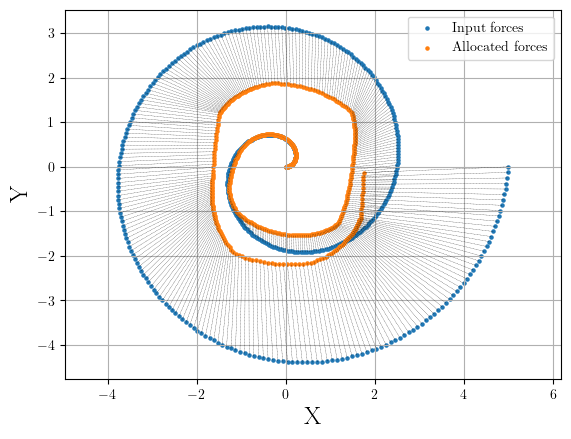

In [4]:

plt.scatter(data[:, 0], data[:, 1], s=5, label="Input forces")
plt.scatter(F[:, 0], F[:, 1], s=5, label="Allocated forces")
for i in range(len(data)):
    plt.plot([data[i, 0], F[i, 0]], [data[i, 1], F[i, 1]], "k--", lw=0.2)

plt.grid(True)
plt.axis('equal')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.show()